In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import cv2
import PIL
import einops
import os

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 112
WIDTH = 112

In [3]:
data_dir = pathlib.Path("./dataset/")

In [4]:
ls

 Volume in drive C has no label.
 Volume Serial Number is EC97-A748

 Directory of C:\Users\Marko\Desktop\SD_project

30/05/2025  09:34    <DIR>          .
29/05/2025  13:49    <DIR>          ..
17/04/2025  12:41    <DIR>          .ipynb_checkpoints
17/04/2025  11:32    <DIR>          dataset
18/05/2025  18:23         2.377.980 Gesture_detector.ipynb
18/05/2025  18:24           829.591 Load_test.ipynb
24/04/2025  09:23            46.752 model.png
08/04/2025  16:29         1.857.296 model_weights_1.h5
10/04/2025  16:26         1.851.920 model_weights_100epochs.h5
30/05/2025  09:34           332.240 Modello NN.docx
               6 File(s)      7.295.779 bytes
               4 Dir(s)  260.051.374.080 bytes free


In [5]:
train_csv = pd.read_csv("dataset/train.csv", header=None, sep=";")
train_csv.columns = ["directory", "gesture", "label"]
train_csv.head()

,directory,gesture,label
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0


In [6]:
test_csv = pd.read_csv("dataset/test.csv", header=None, sep=";")
test_csv.columns = ["directory", "gesture", "label"]
test_csv.head()

,directory,gesture,label
0,WIN_20180925_17_17_04_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_43_01_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_18_01_40_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_18_03_21_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180926_16_46_22_Pro_Left_Swipe_new,Left_Swipe_new,0


In [7]:
data_dir

WindowsPath('dataset')

In [8]:
len(list(data_dir.glob("train/*/*.png")))/30

663.0

In [9]:
data_dir.glob("train/train/*")

<generator object Path.glob at 0x00000260F5105230>

In [10]:
train_sample = test_csv["directory"][15]
train_sample

'WIN_20180926_16_48_40_Pro_Right_Swipe_new'

In [11]:
image_sample_path = list(data_dir.glob("test/"+train_sample+"/*.png"))[0]

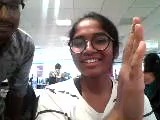

In [12]:
PIL.Image.open(str(image_sample_path))

In [13]:
img = cv2.imread(image_sample_path)
img.shape

(120, 160, 3)

In [14]:
cv2.resize(img, (HEIGHT,WIDTH)).shape

(112, 112, 3)

In [15]:
lables_dict = {
    "Left_Swipe_new": 0,
    "Right_Swipe_new": 1,
    "Stop_new": 2,
    "Thumbs_Down_new": 3,
    "Thumbs_Up_new": 4,
}

In [16]:
classes = ["Left_Swipe_new", "Right_Swipe_new", "Stop_new", "Thumbs_Down_new", "Thumbs_Up_new"]

In [17]:
immagini_cartella = list(data_dir.glob("train/"+train_csv["directory"][0]+"/*"))

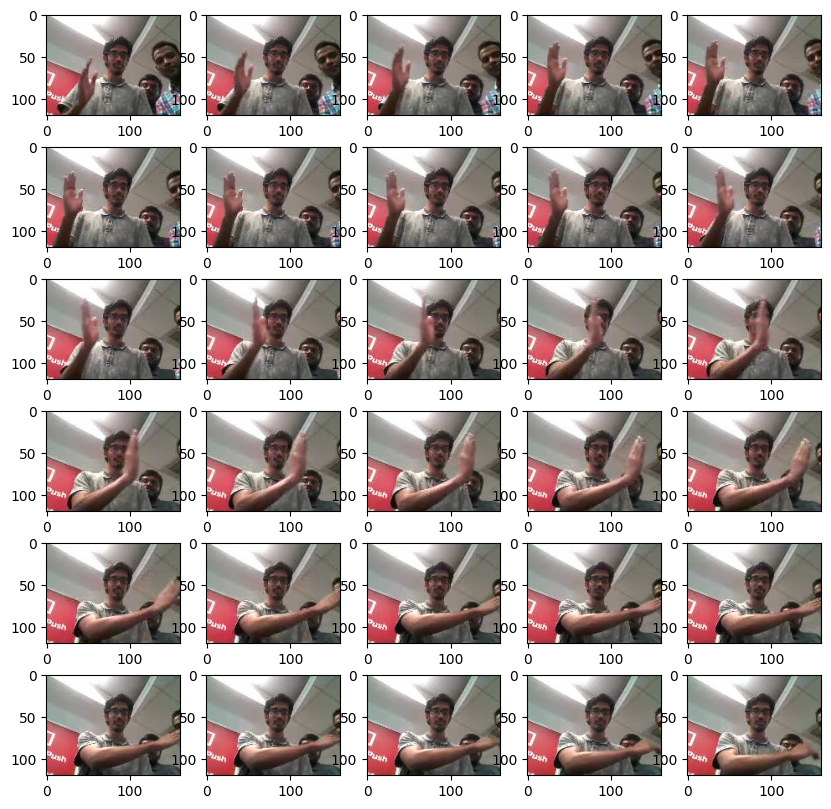

In [18]:
fig, axs = plt.subplots(6, 5, figsize=(10,10))

immagini = [PIL.Image.open(immagini_cartella[n]) for n in range(30)]
for ax, img in zip(axs.ravel(), immagini):
    ax.imshow(img)

In [19]:
def get_frames_from_dir(dir_name, out_dir="train"):
    immagini_cartella = list(data_dir.glob(out_dir+"/"+dir_name+"/*"))
    n_images = len(immagini_cartella)
    
    # frame_list = [PIL.Image.open(immagini_cartella[n]) for n in range(n_images)]
    # print(n_images)

    # reading and resizing all images from the directory
    frame_list = [cv2.resize(cv2.imread(immagini_cartella[n]), (HEIGHT,WIDTH)) for n in range(n_images)]
    return frame_list

In [20]:
a = get_frames_from_dir(train_csv["directory"][0])
b = np.array(a)
b.shape

(30, 112, 112, 3)

In [21]:
X_train = []
y_train = []

for dir_name, label in zip(train_csv["directory"], train_csv["label"]):
    y_train.append(label)
    X_train.append(get_frames_from_dir(dir_name, "train"))

In [22]:
X_test = []
y_test = []

for dir_name, label in zip(test_csv["directory"], test_csv["label"]):
    y_test.append(label)
    X_test.append(get_frames_from_dir(dir_name, "test"))

In [23]:
print("train videos: ",len(X_train))
print("train images: ",len(y_train)*30)
print("test videos: ",len(X_test))
print("test images: ",len(y_test)*30)

train videos:  663
train images:  19890
test videos:  100
test images:  3000


In [24]:
X_train_array = np.array(X_train)/255.0
X_test_array = np.array(X_test)/255.0
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

In [25]:
print(X_train_array.shape)
print(X_test_array.shape)
print(y_train_array.shape)
print(y_test_array.shape)

(663, 30, 112, 112, 3)
(100, 30, 112, 112, 3)
(663,)
(100,)


In [26]:
data_dir.glob("/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/*")

<generator object Path.glob at 0x00000260F515B220>

In [27]:
arr = np.ones([2,2,3])
arr[1] = [[2,2,2],[2,2,2]]
arr

array([[[1., 1., 1.],
        [1., 1., 1.]],

       [[2., 2., 2.],
        [2., 2., 2.]]])

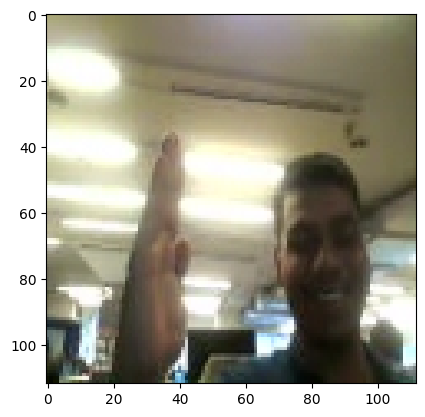

In [28]:
# openCV works with BGR and not RGB so to properly show the image we have to convert the colors first
plt.imshow(cv2.cvtColor(X_train[9][0], cv2.COLOR_BGR2RGB))

<h2>Model</h2>

In [29]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [30]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [31]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [32]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [33]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [34]:

def video_augmentation_layer():
    def augment(video, seed):
        def consistent_augment(frame):
            frame = tf.image.stateless_random_flip_left_right(frame, seed=[seed, 0])
            frame = tf.image.stateless_random_brightness(frame, max_delta=0.2, seed=[seed, 1])
            frame = tf.image.stateless_random_contrast(frame, lower=0.8, upper=1.2, seed=[seed, 2])
            return frame
        video = tf.map_fn(consistent_augment, video)
        return video

    def batch_augment(batch_videos):
        # batch_videos shape: (batch_size, 30, H, W, 3)
        batch_size = tf.shape(batch_videos)[0]
        seeds = tf.random.uniform(shape=(batch_size,), maxval=10000, dtype=tf.int32)
        
        # Applica augment con seed individuale per ogni video
        augmented = tf.map_fn(
            lambda x: augment(x[0], x[1]),
            (batch_videos, seeds),
            dtype=batch_videos.dtype
        )
        return augmented

    return layers.Lambda(batch_augment)

In [36]:
input_shape = (None, 30, HEIGHT, WIDTH, 3)
inputs = layers.Input(shape=(input_shape[1:]))
x = inputs

# -------------------- data augemntation ------
#x = video_augmentation_layer()(input)
# --------------------

# -------------------- data augmentation ------
# Applica il layer personalizzato SOLO durante l'addestramento
x = TemporallyConsistentBrightness(brightness_delta_range=(-30.0, 30.0))(x)
# --------------------

x = Conv2Plus1D(filters=16, kernel_size=(3, 5, 5), padding='same')(x) # originale era (3, 7, 7)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
#x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x) # scommentare in caso

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(5)(x) # aggiunta softmax finale
#x = layers.Dense(5, activation='softmax')(x) # aggiunta softmax finale

model = keras.Model(inputs, x)

In [37]:
#frames, label = next(iter(train_ds))
#model.build(X_train_array)

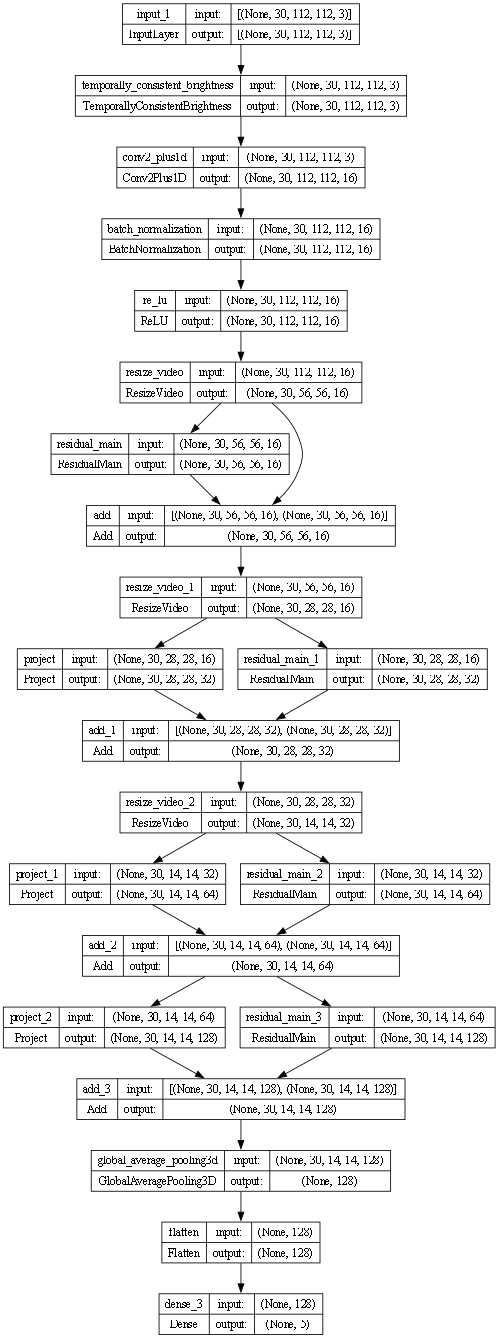

In [38]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 112, 11  0           []                               
                                2, 3)]                                                            
                                                                                                  
 conv2_plus1d (Conv2Plus1D)     (None, 30, 112, 112  2000        ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 30, 112, 112  64         ['conv2_plus1d[0][0]']           
 alization)                     , 16)                                                         

In [40]:
model.compile(loss = keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [41]:
num_classes = 5
y_train_array_categorical = to_categorical(y_train_array, num_classes=num_classes)
y_test_array_categorical = to_categorical(y_test_array, num_classes=num_classes)

In [42]:
history = model.fit(X_train_array, y_train_array_categorical, epochs = 100)

Epoch 1/100
21/21 [==============================] - 19s 496ms/step - loss: 1.6973 - accuracy: 0.2805
Epoch 2/100
21/21 [==============================] - 10s 479ms/step - loss: 1.4347 - accuracy: 0.3816
Epoch 3/100
21/21 [==============================] - 10s 481ms/step - loss: 1.3583 - accuracy: 0.3891
Epoch 4/100
21/21 [==============================] - 10s 478ms/step - loss: 1.3116 - accuracy: 0.4253
Epoch 5/100
21/21 [==============================] - 10s 482ms/step - loss: 1.2855 - accuracy: 0.4344
Epoch 6/100
21/21 [==============================] - 10s 482ms/step - loss: 1.1746 - accuracy: 0.5189
Epoch 7/100
21/21 [==============================] - 10s 485ms/step - loss: 1.0939 - accuracy: 0.5520
Epoch 8/100
21/21 [==============================] - 10s 485ms/step - loss: 1.0753 - accuracy: 0.5460
Epoch 9/100
21/21 [==============================] - 10s 478ms/step - loss: 1.0608 - accuracy: 0.5596
Epoch 10/100
21/21 [==============================] - 10s 475ms/step - loss: 0.976

In [41]:
# saving the weights
# model.save_weights("model_weights_1.h5")
model.load_weights("model_weights_100epochs.h5")

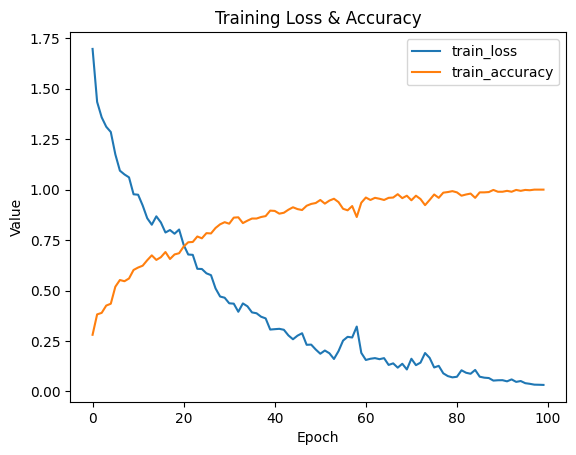

In [50]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.legend()
plt.title('Training Loss & Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

KeyError: 'val_loss'

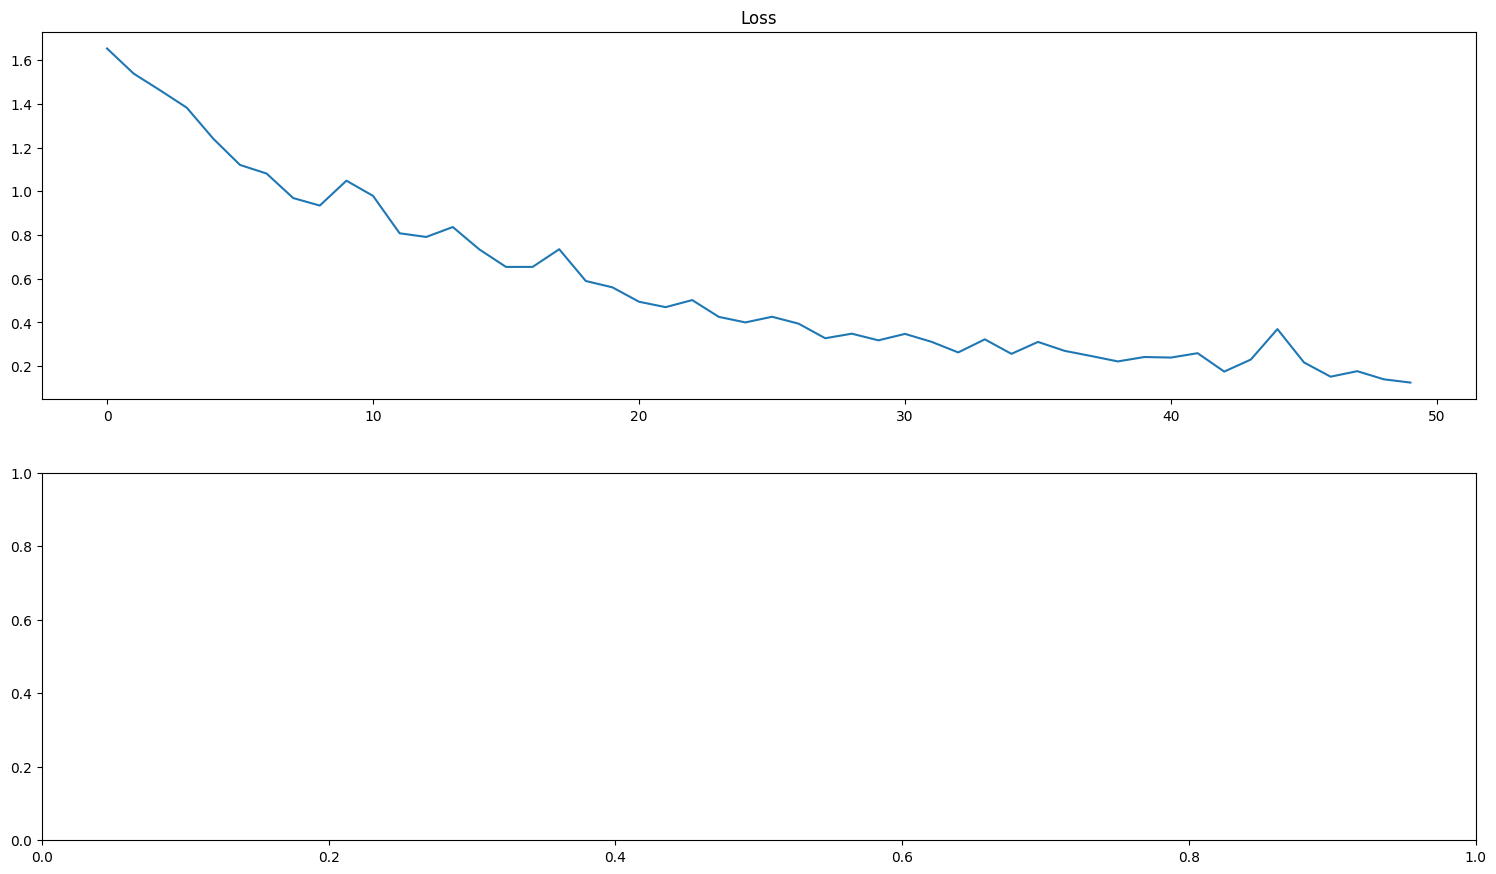

In [76]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [51]:
model.evaluate(X_test_array, y_test_array_categorical, return_dict=True)

4/4 [==============================] - 1s 138ms/step - loss: 0.3158 - accuracy: 0.9000


{'loss': 0.3157635033130646, 'accuracy': 0.8999999761581421}

In [52]:
y_pred = [np.argmax(p) for p in model.predict(X_test_array)]

4/4 [==============================] - 2s 129ms/step


<Axes: >

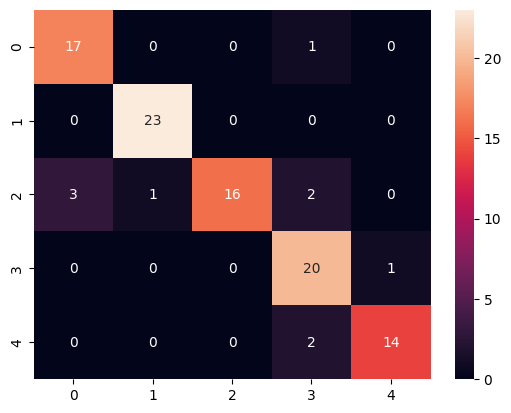

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

<h2>My test</h2>

In [15]:
def load_videos_from_folder(folder_path, num_frames=30, frame_size=(HEIGHT, WIDTH)):
    videos_array = []
    
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
            video_path = os.path.join(folder_path, filename)
            cap = cv2.VideoCapture(video_path)

            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if total_frames < num_frames:
                print(f"⚠️  {filename}: meno di {num_frames} frame, verranno duplicati gli ultimi frame.")

            # Calcola gli indici dei frame da prendere
            frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

            video_frames = []

            current_index = 0
            frame_pos = 0

            while cap.isOpened() and len(video_frames) < num_frames:
                ret, frame = cap.read()
                if not ret:
                    break

                if current_index == frame_indices[frame_pos]:
                    frame_resized = cv2.resize(frame, frame_size)
                    video_frames.append(frame_resized)
                    frame_pos += 1
                    if frame_pos >= len(frame_indices):
                        break

                current_index += 1

            cap.release()

            # Padding se video troppo corto
            while len(video_frames) < num_frames:
                video_frames.append(video_frames[-1])

            videos_array.append(video_frames)

    return np.array(videos_array)  # Shape: (num_video, 30, HEIGHT, WIDTH, 3)

In [16]:
def load_most_moving_frames_from_folder(folder_path, num_frames=30, frame_size=(HEIGHT, WIDTH)):
    videos_array = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
            video_path = os.path.join(folder_path, filename)
            cap = cv2.VideoCapture(video_path)
            color_frames = []
            gray_frames = []

            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                resized = cv2.resize(frame, frame_size)
                color_frames.append(resized)
                gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
                gray_frames.append(gray)

            cap.release()

            total_frames = len(gray_frames)
            if total_frames == 0:
                print(f"⚠️  {filename}: video vuoto.")
                continue

            # Se ci sono meno di due frame, padding diretto
            if total_frames < 2:
                print(f"⚠️  {filename}: troppo pochi frame, duplicazione.")
                color_frames = color_frames * (num_frames // len(color_frames) + 1)
                selected_frames = color_frames[:num_frames]
            else:
                diffs = []
                for i in range(1, total_frames):
                    diff = np.sum(np.abs(gray_frames[i] - gray_frames[i-1]))
                    diffs.append((diff, i))

                # Prendi i frame con più movimento
                diffs.sort(reverse=True)
                best_indices = sorted([idx for (_, idx) in diffs[:min(num_frames, len(diffs))]])

                selected_frames = [color_frames[i] for i in best_indices]

                # Padding se meno di num_frames
                while len(selected_frames) < num_frames:
                    selected_frames.append(selected_frames[-1])

            videos_array.append(selected_frames)

    return np.array(videos_array)  # Shape: (num_video, 30, h, w, 3)

In [17]:
def load_most_moving_frames_from_folder(folder_path, num_frames=30, frame_size=(HEIGHT, WIDTH)):
    videos_array = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
            video_path = os.path.join(folder_path, filename)
            cap = cv2.VideoCapture(video_path)
            color_frames = []
            gray_frames = []

            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                resized = cv2.resize(frame, frame_size)
                color_frames.append(resized)
            cap.release()

            total_frames = len(color_frames)

            diffs = []
            for i in range(1, total_frames):
                diff = np.sum(np.abs(color_frames[i] - color_frames[i-1]))
                diffs.append((diff, i))

            # Prendi i frame con più movimento
            diffs.sort(reverse=True)
            best_indices = sorted([idx for (_, idx) in diffs[:min(num_frames, len(diffs))]])

            selected_frames = [color_frames[i] for i in best_indices]

            # Padding se meno di num_frames
            while len(selected_frames) < num_frames:
                selected_frames.append(selected_frames[-1])

            videos_array.append(selected_frames)

    return np.array(videos_array)  # Shape: (num_video, 30, h, w, 3)

In [18]:
def load_most_moving_frames_from_folder_square_then_resize(folder_path, num_frames=30, frame_size=(HEIGHT, WIDTH)):
    videos_array = []
    video_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    for filename in sorted(video_files):
        video_path = os.path.join(folder_path, filename)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            continue

        color_frames_processed = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            h, w, _ = frame.shape
            max_dim = max(h, w)
            square_frame = np.zeros((max_dim, max_dim, 3), dtype=np.uint8)
            pad_top = (max_dim - h) // 2
            pad_left = (max_dim - w) // 2
            square_frame[pad_top:pad_top + h, pad_left:pad_left + w] = frame
            resized_frame = cv2.resize(square_frame, frame_size, interpolation=cv2.INTER_AREA)
            color_frames_processed.append(resized_frame)

        cap.release()

        if not color_frames_processed:
             continue

        total_frames = len(color_frames_processed)
        diffs = []
        selected_frames = []

        if total_frames > 1:
            for j in range(1, total_frames):
                frame1 = color_frames_processed[j-1].astype(np.float32)
                frame2 = color_frames_processed[j].astype(np.float32)
                diff = np.sum(np.abs(frame2 - frame1))
                diffs.append((diff, j))

            diffs.sort(key=lambda x: x[0], reverse=True)
            best_indices = sorted([idx for (_, idx) in diffs[:min(num_frames, len(diffs))]])

            if len(best_indices) < num_frames and 0 not in best_indices:
                 if total_frames > 0:
                    best_indices.insert(0, 0)

            selected_frames = [color_frames_processed[k] for k in best_indices]

        elif total_frames == 1:
             selected_frames = [color_frames_processed[0]]
        else:
             continue

        if selected_frames:
            while len(selected_frames) < num_frames:
                selected_frames.append(selected_frames[-1].copy())
        else:
            black_frame = np.zeros((frame_size[0], frame_size[1], 3), dtype=np.uint8)
            selected_frames = [black_frame] * num_frames

        videos_array.append(selected_frames)

    return np.array(videos_array)

In [54]:
def load_most_moving_frames_center_crop(folder_path, num_frames=30, frame_size=(HEIGHT, WIDTH)):
    videos_array = []
    video_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    
    diffs_results = []
    for filename in sorted(video_files):
        video_path = os.path.join(folder_path, filename)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            continue

        color_frames_processed = []
        
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            h, w, _ = frame.shape
            cropped_frame = None

            if w > h: # Landscape
                min_dim = h
                start_col = (w - h) // 2
                cropped_frame = frame[:, start_col:start_col + min_dim]
            elif h > w: # Portrait
                min_dim = w
                start_row = (h - w) // 2
                cropped_frame = frame[start_row:start_row + min_dim, :]
            else: # Already square
                cropped_frame = frame

            # Ridimensiona il frame ritagliato (che è quadrato) alla dimensione finale
            if cropped_frame is not None:
                 resized_frame = cv2.resize(cropped_frame, frame_size, interpolation=cv2.INTER_AREA)
                 color_frames_processed.append(resized_frame)

        cap.release()

        if not color_frames_processed:
             continue

        total_frames = len(color_frames_processed)
        diffs = []
        selected_frames = []
        
        
        
        if total_frames > 1:
            for j in range(1, total_frames):
                frame1 = color_frames_processed[j-1].astype(np.float32)
                frame2 = color_frames_processed[j].astype(np.float32)
                diff = np.sum(np.abs(frame2 - frame1))
                diffs.append((diff, j))

            diffs_results.append(diffs.copy())
            diffs.sort(key=lambda x: x[0], reverse=True)
            best_indices = sorted([idx for (_, idx) in diffs[:min(num_frames, len(diffs))]])

            if len(best_indices) < num_frames and 0 not in best_indices:
                 if total_frames > 0:
                    best_indices.insert(0, 0)

            selected_frames = [color_frames_processed[k] for k in best_indices]

        elif total_frames == 1:
             selected_frames = [color_frames_processed[0]]
        else:
             continue

        if selected_frames:
            while len(selected_frames) < num_frames:
                selected_frames.append(selected_frames[-1].copy())
        else:
            black_frame = np.zeros((frame_size[0], frame_size[1], 3), dtype=np.uint8)
            selected_frames = [black_frame] * num_frames

        videos_array.append(selected_frames)

    return np.array(videos_array), diffs_results

In [47]:
my_videos_1 = load_most_moving_frames_center_crop("dataset/my_test/1/")
my_videos_2 = load_most_moving_frames_center_crop("dataset/my_test/2/")
my_videos_3 = load_most_moving_frames_center_crop("dataset/my_test/3_already_good/")
my_videos_all = np.concatenate((my_videos_1, my_videos_2, my_videos_3), axis=0)
my_videos_all.shape

(28, 30, 112, 112, 3)

In [90]:
#my_videos = extract_gesture_frames("dataset/my_test/2", num_frames=30, frame_size=(WIDTH, HEIGHT))
#my_videos = load_most_moving_frames_from_folder("dataset/my_test/3_already_good/") # questo è quello base
my_videos = load_most_moving_frames_center_crop("dataset/my_test/2")

In [95]:
caca = (X_test_array*255.0).astype(np.uint8)
caca.shape

(100, 30, 112, 112, 3)

(100, 30, 112, 112, 3)

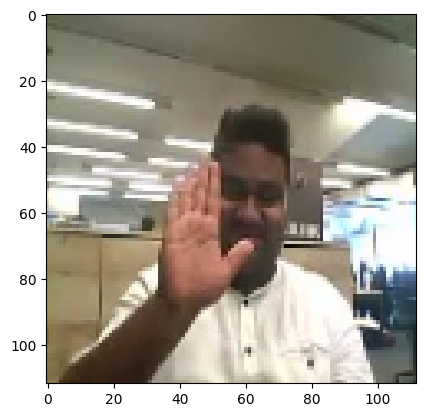

In [106]:
plt.imshow(cv2.cvtColor(caca[27][15], cv2.COLOR_BGR2RGB))
caca.shape

(9, 30, 112, 112, 3)

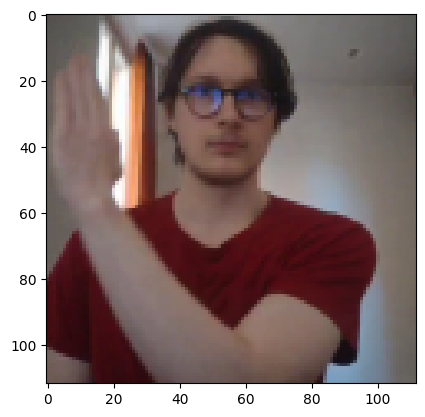

In [93]:
plt.imshow(cv2.cvtColor(my_videos[2][15], cv2.COLOR_BGR2RGB))
my_videos.shape

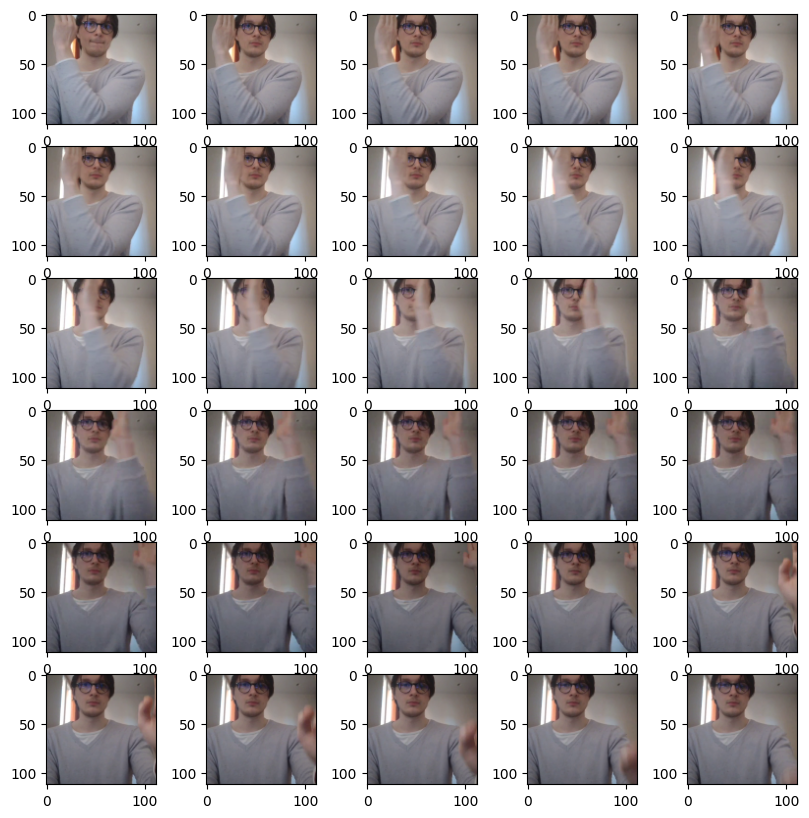

In [91]:
fig, axs = plt.subplots(6, 5, figsize=(10,10))

for ax, frame in zip(axs.ravel(), range(30)):
    ax.imshow(cv2.cvtColor(my_videos[0][frame], cv2.COLOR_BGR2RGB))

In [92]:
my_videos_normalized = my_videos/255.0
my_pred = model.predict(my_videos_normalized)

i = 0
for r in my_pred:
    print(i, "--->", classes[np.argmax(r)])
    i += 1
    print(r)
    print("-----------------------------------------")

1/1 [==============================] - 0s 79ms/step
0 ---> Thumbs_Down_new
[-2.4175334  -3.420535    0.11625329  3.722852    1.7217063 ]
-----------------------------------------
1 ---> Thumbs_Down_new
[ 1.301294  -1.0695305 -0.718131   2.3788462 -2.0310118]
-----------------------------------------
2 ---> Thumbs_Down_new
[-1.9853758   1.0337064  -0.81228054  1.4386015  -0.93589526]
-----------------------------------------
3 ---> Thumbs_Down_new
[-2.8811347   1.3804251  -1.2461774   1.681518   -0.50029594]
-----------------------------------------
4 ---> Thumbs_Down_new
[-0.87948143 -5.5452824  -0.47952682  7.272133   -0.9708567 ]
-----------------------------------------
5 ---> Thumbs_Down_new
[ 0.6450429 -2.3562799 -1.6173136  4.970087  -2.3086326]
-----------------------------------------
6 ---> Thumbs_Down_new
[-0.613548  -4.027678  -1.2017244  6.3348365 -1.400137 ]
-----------------------------------------
7 ---> Thumbs_Down_new
[ 1.2339166 -2.1563401 -1.6711302  4.827323  -2.724

In [86]:
lables_dict

{'Left_Swipe_new': 0,
 'Right_Swipe_new': 1,
 'Stop_new': 2,
 'Thumbs_Down_new': 3,
 'Thumbs_Up_new': 4}

<h2>Test - Mine</h2>

In [45]:
dirs = pathlib.Path("./dataset/my_test_categorized")
video_list = []
category = 0
y_mine = []

for dir_name in dirs.iterdir():
    print(dir_name)
    videos = load_most_moving_frames_center_crop(dir_name)
    video_list.append(videos)

    n_videos = videos.shape[0]
    y_mine += n_videos*[category]
    category += 1
    
X_mine = np.concatenate(video_list, axis=0)
X_mine.shape

dataset\my_test_categorized\0 - Left_Swipe
dataset\my_test_categorized\1 - Right_Swipe
dataset\my_test_categorized\2 - Stop
dataset\my_test_categorized\3 - Thumbs_Down
dataset\my_test_categorized\4 - Thumbs_Up


(25, 30, 112, 112, 3)

In [46]:
X_train_mine, X_test_mine, y_train_mine, y_test_mine = train_test_split(X_mine, y_mine, test_size=0.2)
y_train_mine = np.array(y_train_mine)
num_classes = 5

X_train_mine = X_train_mine / 255.0
X_test_mine = X_test_mine / 255.0
y_train_mine = to_categorical(y_train_mine, num_classes=num_classes)
y_test_mine = to_categorical(y_test_mine, num_classes=num_classes)
y_test_mine

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [116]:
model.fit(X_train_mine, y_train_mine, epochs = 100)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.8943 - accuracy: 0.2500
Epoch 2/100
1/1 [==============================] - 0s 302ms/step - loss: 1.7354 - accuracy: 0.3000
Epoch 3/100
1/1 [==============================] - 0s 300ms/step - loss: 1.7728 - accuracy: 0.3000
Epoch 4/100
1/1 [==============================] - 0s 302ms/step - loss: 1.5981 - accuracy: 0.3000
Epoch 5/100
1/1 [==============================] - 0s 299ms/step - loss: 1.5398 - accuracy: 0.3000
Epoch 6/100
1/1 [==============================] - 0s 306ms/step - loss: 1.5473 - accuracy: 0.3000
Epoch 7/100
1/1 [==============================] - 0s 306ms/step - loss: 1.5620 - accuracy: 0.2500
Epoch 8/100
1/1 [==============================] - 0s 301ms/step - loss: 1.5028 - accuracy: 0.3000
Epoch 9/100
1/1 [==============================] - 0s 296ms/step - loss: 1.4396 - accuracy: 0.4500
Epoch 10/100
1/1 [==============================] - 0s 301ms/step - loss: 1.4232 - accuracy: 0.4000
Epoch 11/100

In [47]:
model.evaluate(X_test_mine, y_test_mine)

1/1 [==============================] - 1s 1s/step - loss: 5.9266 - accuracy: 0.2000


[5.926574230194092, 0.20000000298023224]

In [48]:
model.evaluate(X_train_mine, y_train_mine)

1/1 [==============================] - 0s 154ms/step - loss: 4.9722 - accuracy: 0.2500


[4.972227573394775, 0.25]

In [35]:
class TemporallyConsistentBrightness(layers.Layer):
    """
    Applica un aggiustamento di luminosità casuale ma temporalmente consistente.

    Genera un singolo delta di luminosità per ogni video nel batch
    e lo applica a tutti i frame di quel video.
    Opera solo durante l'addestramento.

    Args:
        brightness_delta_range (tuple): Intervallo (min, max) per il delta
                                         di luminosità da aggiungere.
                                         Assumes input pixel values are in [0, 255].
        name (str, optional): Nome del layer.
    """
    def __init__(self, brightness_delta_range=(-30.0, 30.0), name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.brightness_delta_range = brightness_delta_range
        # Convert range to float32 as calculations will be in float
        self.min_delta = tf.constant(brightness_delta_range[0], dtype=tf.float32)
        self.max_delta = tf.constant(brightness_delta_range[1], dtype=tf.float32)

    def call(self, inputs, training=None):
        if training:
            # Assicura che l'input sia float32 per i calcoli
            inputs_float = tf.cast(inputs, tf.float32)

            # Ottieni la dimensione del batch dinamicamente
            batch_size = tf.shape(inputs_float)[0]

            # Genera un delta di luminosità casuale per ogni video nel batch
            # Shape: (batch_size,)
            brightness_deltas = tf.random.uniform(
                shape=(batch_size,),
                minval=self.min_delta,
                maxval=self.max_delta,
                dtype=tf.float32
            )

            # Riformatta il delta per il broadcasting corretto sulle dimensioni
            # di frame, altezza, larghezza e canali.
            # Shape target: (batch_size, 1, 1, 1, 1)
            # Questo fa sì che lo stesso delta venga sommato a tutti i frame, pixel
            # e canali di un dato video nel batch.
            broadcast_shape = tf.concat(
                [tf.shape(brightness_deltas), [1, 1, 1, 1]], axis=0
            )
            deltas_broadcast = tf.reshape(brightness_deltas, broadcast_shape)

            # Aggiungi il delta di luminosità
            augmented_float = inputs_float + deltas_broadcast

            # Ritaglia i valori per rimanere nell'intervallo [0.0, 255.0]
            # ATTENZIONE: Se i tuoi dati NON sono in [0, 255] ma normalizzati
            # (es. [0, 1] o [-1, 1]), devi aggiustare questo clipping range!
            augmented_clipped = tf.clip_by_value(augmented_float, 0.0, 255.0)

            # Restituisci il risultato (generalmente si mantiene float32 per i layer successivi)
            # Se necessario, puoi riconvertire al dtype originale:
            # result = tf.cast(augmented_clipped, inputs.dtype)
            result = augmented_clipped
            return result
        else:
            # Nessuna augmentation durante l'inferenza/valutazione
            return inputs

    def get_config(self):
        # Necessario per salvare/caricare il modello che usa questo layer
        config = super().get_config()
        config.update({
            "brightness_delta_range": self.brightness_delta_range,
        })
        return config

In [79]:
my_videos_1, a = load_most_moving_frames_center_crop("dataset/my_test/3_already_good/")

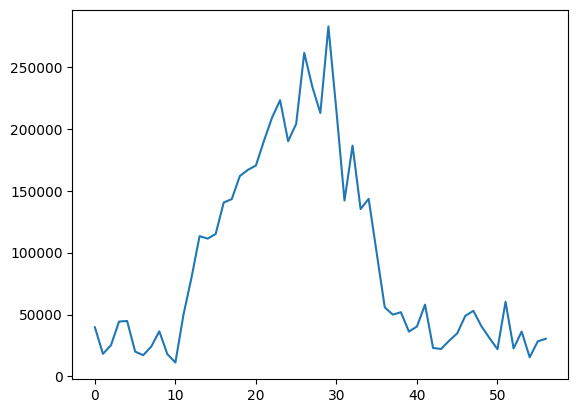

In [88]:
vals = []
for val, i in a[5]:
    vals.append(val)
plt.plot(vals)